In [35]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split


In [36]:
print(os.getcwd())
print(os.listdir())

/Users/donaldmurataj/Documents/Development/Paidy/credit-risk-prediction/src/credit_risk_prediction
['.DS_Store', 'modeling.ipynb', '__init__.py', 'py.typed', 'data', 'analysis.ipynb']


In [37]:
# Load datasets and ignore "Unnamed: 0" column on read
training_df = pd.read_csv("data/cs-training.csv", usecols=lambda c: c != "Unnamed: 0")
test_df = pd.read_csv("data/cs-test.csv", usecols=lambda c: c != "Unnamed: 0")

# Define type groups
int_columns = [
    'SeriousDlqin2yrs', 'age', 'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
]

float_columns = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']

# Convert types
training_df[int_columns] = training_df[int_columns].astype('Int64')
training_df[float_columns] = training_df[float_columns].astype(float)

test_df[int_columns] = test_df[int_columns].astype('Int64')
test_df[float_columns] = test_df[float_columns].astype(float)

# Preview result
training_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0


In [38]:
print(training_df.shape)
print(test_df.shape)

(150000, 11)
(101503, 11)


In [39]:
# 1/3 of test data should be the actual test data, other 2/3rds I want as validation
validation_df = test_df.sample(n=67000, random_state=42)

# The remaining rows become the validation set
test_df = test_df.drop(validation_df.index)

# Reset indexes
test_df = test_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

# Check
print(f"Training set: {training_df.shape}")
print(f"Validation set: {validation_df.shape}")
print(f"Test set (final): {test_df.shape}")

Training set: (150000, 11)
Validation set: (67000, 11)
Test set (final): (34503, 11)


### Merge data into one for easier null removal and overall data analysis

In [40]:
# Optional: add a marker to know which rows are train vs test
training_df['dataset'] = 'train'
validation_df['dataset'] = 'validation'
test_df['dataset'] = 'test'

# Concatenate into one DataFrame
full_df = pd.concat([training_df, validation_df, test_df], ignore_index=True)
full_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,dataset
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2,train
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1,train
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0,train
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0,train
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0,train


### Assume null delinquency or dependants just means 0 (We'll deal with income later)

In [41]:
full_df[['NumberOfDependents', 'SeriousDlqin2yrs']] = (
    full_df[['NumberOfDependents', 'SeriousDlqin2yrs']].fillna(0)
)

null_counts = full_df.isnull().sum()
print(null_counts)

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           49834
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                          0
dataset                                     0
dtype: int64


### Variable Transformations

#### Dealing with late payers

In [43]:
# Create binary variables for "ever late" vs "never late"

# 30–59 days past due
full_df['30_59DaysPastDueNotWorse'] = (full_df['NumberOfTime30-59DaysPastDueNotWorse'] > 0).astype(int)
full_df['never_30_59DaysPastDueNotWorse'] = (full_df['NumberOfTime30-59DaysPastDueNotWorse'] == 0).astype(int)

# 60–89 days past due
full_df['60_89DaysPastDueNotWorse'] = (full_df['NumberOfTime60-89DaysPastDueNotWorse'] > 0).astype(int)
full_df['never_60_89DaysPastDueNotWorse'] = (full_df['NumberOfTime60-89DaysPastDueNotWorse'] == 0).astype(int)

# 90+ days late
full_df['90DaysLate'] = (full_df['NumberOfTimes90DaysLate'] > 0).astype(int)
full_df['never_90DaysLate'] = (full_df['NumberOfTimes90DaysLate'] == 0).astype(int)

# Check the distribution to confirm
for col in ['30_59DaysPastDueNotWorse', '60_89DaysPastDueNotWorse', '90DaysLate']:
    print(f"\n{col} value counts:")
    print(full_df[col].value_counts(normalize=True).round(4) * 100)



30_59DaysPastDueNotWorse value counts:
30_59DaysPastDueNotWorse
0    83.98
1    16.02
Name: proportion, dtype: float64

60_89DaysPastDueNotWorse value counts:
60_89DaysPastDueNotWorse
0    94.94
1     5.06
Name: proportion, dtype: float64

90DaysLate value counts:
90DaysLate
0    94.41
1     5.59
Name: proportion, dtype: float64


#### Dealing with Ratios

In [44]:
# --- DebtRatio ---
full_df['debtRatio_less_than_1'] = (full_df['DebtRatio'] < 1).astype(int)
full_df['debtRatio_1_or_more'] = (full_df['DebtRatio'] >= 1).astype(int)

# --- RevolvingUtilizationOfUnsecuredLines ---
full_df['RevolvingUtilizationOfUnsecuredLines_less_than_1'] = (
    full_df['RevolvingUtilizationOfUnsecuredLines'] < 1
).astype(int)

full_df['RevolvingUtilizationOfUnsecuredLines_1_or_more'] = (
    full_df['RevolvingUtilizationOfUnsecuredLines'] >= 1
).astype(int)


debtRatio_less_than_1 value counts (%):
debtRatio_less_than_1
1    76.5
0    23.5
Name: proportion, dtype: float64

debtRatio_1_or_more value counts (%):
debtRatio_1_or_more
0    76.5
1    23.5
Name: proportion, dtype: float64

RevolvingUtilizationOfUnsecuredLines_less_than_1 value counts (%):
RevolvingUtilizationOfUnsecuredLines_less_than_1
1    97.8
0     2.2
Name: proportion, dtype: float64

RevolvingUtilizationOfUnsecuredLines_1_or_more value counts (%):
RevolvingUtilizationOfUnsecuredLines_1_or_more
0    97.8
1     2.2
Name: proportion, dtype: float64


In [45]:
# --- Summary for DebtRatio ---
debt_ratio_summary = pd.DataFrame({
    'Category': ['DebtRatio < 1', 'DebtRatio ≥ 1'],
    'Count': [
        (full_df['DebtRatio'] < 1).sum(),
        (full_df['DebtRatio'] >= 1).sum()
    ]
})
debt_ratio_summary['Percent'] = (debt_ratio_summary['Count'] / len(full_df) * 100).round(2)
print("DebtRatio Summary:\n")
print(debt_ratio_summary.to_string(index=False))


# --- Summary for RevolvingUtilizationOfUnsecuredLines ---
rev_util_summary = pd.DataFrame({
    'Category': ['RevolvingUtilizationOfUnsecuredLines < 1', 'RevolvingUtilizationOfUnsecuredLines ≥ 1'],
    'Count': [
        (full_df['RevolvingUtilizationOfUnsecuredLines'] < 1).sum(),
        (full_df['RevolvingUtilizationOfUnsecuredLines'] >= 1).sum()
    ]
})
rev_util_summary['Percent'] = (rev_util_summary['Count'] / len(full_df) * 100).round(2)
print("\nRevolvingUtilizationOfUnsecuredLines Summary:\n")
print(rev_util_summary.to_string(index=False))

DebtRatio Summary:

     Category  Count  Percent
DebtRatio < 1 192411     76.5
DebtRatio ≥ 1  59092     23.5

RevolvingUtilizationOfUnsecuredLines Summary:

                                Category  Count  Percent
RevolvingUtilizationOfUnsecuredLines < 1 245972     97.8
RevolvingUtilizationOfUnsecuredLines ≥ 1   5531      2.2


#### Let's Analyze Monthly Income a bit further

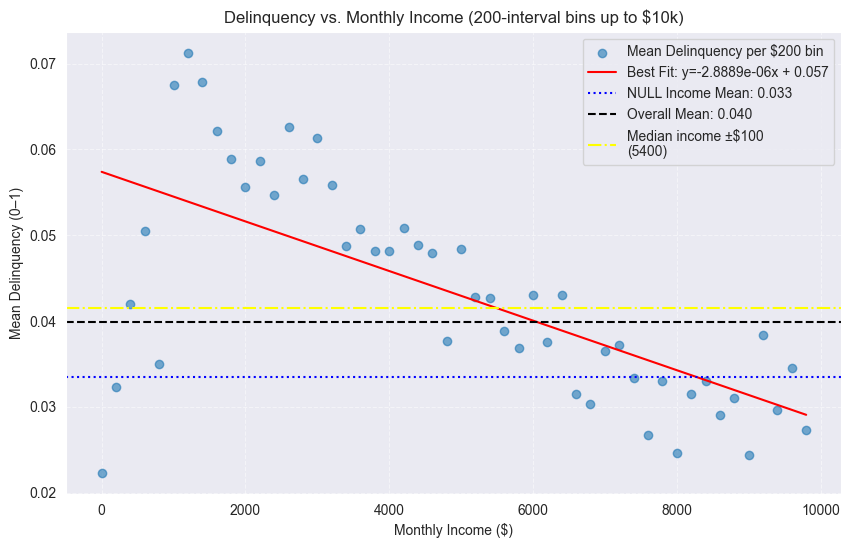

In [50]:
# Define income bins
def income_group(income):
    if pd.isnull(income):
        return 'Null'
    elif income < 500:
        return '<500'
    elif 500 <= income < 2000:
        return '500–2000'
    elif 2000 <= income < 5000:
        return '2000–5000'
    else:
        return '5000+'

# Apply the function
full_df['IncomeGroup'] = full_df['MonthlyIncome'].apply(income_group)

# Calculate delinquency percentage for each group
delinquency_rate = (
    full_df.groupby('IncomeGroup')['SeriousDlqin2yrs']
    .mean()
    .mul(100)
    .round(2)
    .reset_index()
    .rename(columns={'SeriousDlqin2yrs': 'Delinquency %'})
    .sort_values(by='Delinquency %', ascending=False)
)

print(delinquency_rate)


  IncomeGroup  Delinquency %
2    500–2000           5.96
0   2000–5000           5.26
4        Null           3.35
1       5000+           3.29
3        <500            2.4


In [ ]:
30_59DaysPastDueNotWorse
never_30_59DaysPastDueNotWorse
60_89DaysPastDueNotWorse
never_60_89DaysPastDueNotWorse
90DaysLate
never_90DaysLate
debtRatio_less_than_1
debtRatio_1_or_more
RevolvingUtilizationOfUnsecuredLines_less_than_1
RevolvingUtilizationOfUnsecuredLines_1_or_more